# And then there was data

Right, now we have an incling of the method we might use to get arms from a galaxy, let's see how it fares against actual data (from the beta of galaxy-builder)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from ipywidgets import FloatProgress
from IPython.display import display
import json
with open('classification-dump.json') as f: classifications = json.load(f)
with open('subject-dump.json') as f: subjects = json.load(f)

In [2]:
# print(json.dumps(list(cls[0]['links']['subjects']), indent=1))
index, foo = (next(iter(filter(
    lambda s: s[1] == '6ee8db8f-2a1e-4d10-bcb9-1e5ec84f8f10',
    ((i, list(s['locations'][0].items())[0][1].split('/')[-1].split('.')[0]) for i, s in enumerate(subjects))
))))
subjectId = subjects[index]['id']
print(subjectId)

14813274


In [3]:
cls = list(filter(lambda c: c['links']['subjects'][0] == subjectId, classifications))
annotations = [c['annotations'] for c in cls]
annotationsWithSpiral = [c[3]['value'][0]['value'] for c in annotations if len(c[3]['value'][0]['value'])]
spirals = [[a['points'] for a in c] for c in annotationsWithSpiral]
spiralsWithLengthCut = [
    [
        [[p['x'], p['y']] for p in a] 
        for a in c
    ]
    for c in spirals if all([len(a) > 5 for a in c])
]

To ensure we've grabbed things correctly, let's plot all our drawn arms!

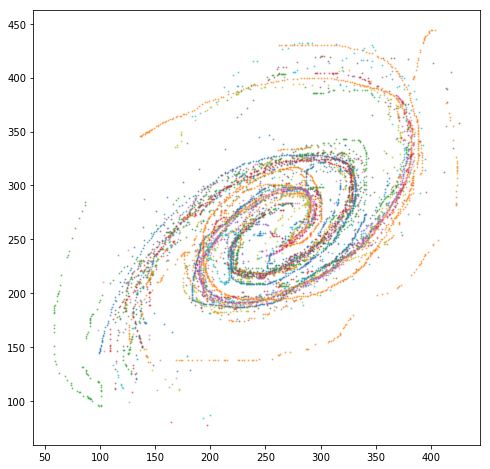

In [4]:
plt.figure(figsize=(8, 8))
for arms in spiralsWithLengthCut:
    for arm in arms:
        plt.plot([i[0] for i in arm], [i[1] for i in arm], '.', markersize=2, alpha=0.5)

It looks good! ALbeit very messy... Now to run the extraction on it

First step is to move the array of classifications into an array of drawn arms (ignoring the potentially useful information that each volunteer will only have drawn each arm once...)

In [5]:
drawnArms = np.array([np.array(arm) for classification in spiralsWithLengthCut for arm in classification])

## Import the algorithm

Because I don't know how to best use jupyter, redo some of the cells from the previous chapter:

In [6]:
# calculate dot(a) of a(n,2), b(n,2): np.add.reduce(b1 * b2, axis=1)
# calucalte norm(a) of a(n,2), b(n,2): np.add.reduce((a-b)**2, axis=1)
def calcT(a):
    b1 = a[:, 0, :] - a[:, 1, :]
    b2 = a[:, 2, :] - a[:, 1, :]
    dots = np.add.reduce(b1 * b2, axis=1)
    l2 = np.add.reduce((a[:, 1] - a[:, 2])**2, axis=1)
    out = np.clip(dots / l2, 0, 1)
    return out

def getDiff(t, a):
    projection = a[:,1,:] + np.repeat(t.reshape(-1, 1), 2, axis=1) * (a[:,2,:] - a[:,1,:])
    out = np.add.reduce((a[:,0,:]-projection) * (a[:,0,:]-projection), axis=1)
    return np.sqrt(np.min(out))

vCalcT = np.vectorize(calcT, signature='(a,b,c)->(a)')
vGetDiff = np.vectorize(getDiff, signature='(a),(a,b,c)->()')

def minimum_distance(a, b):
    d = 0
#     print(np.roll(b, 1, axis=0))
    m = np.zeros((a.shape[0], b.shape[0]-1, 3, 2))
    m[:, :, 0, :] = np.transpose(np.tile(a, [m.shape[1]+1, 1, 1]), axes=[1, 0, 2])[:, :-1, :]
    m[:, :, 1, :] = np.tile(b, [a.shape[0], 1, 1])[:, :-1, :]
    m[:, :, 2, :] = np.tile(np.roll(b, -1, axis=0), [a.shape[0], 1, 1])[:, :-1, :]
    t = vCalcT(np.array(m))
    return np.sum(vGetDiff(t, m))/a.shape[0]
    
def arcDistanceFast(a, b):
    return (
        minimum_distance(a, b) +
        minimum_distance(b, a)
    )

# %timeit arcDistanceFast(noisy1, noisy2)

## Identifying arms

First, create the distances array as before:

59.56167697906494


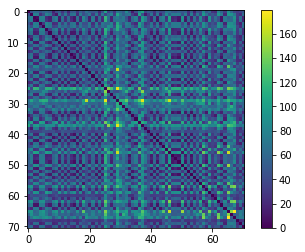

In [7]:
import time
def calculateDistanceMatrix(cls):
    n = len(cls)**2/2 - len(cls)/2
    f = FloatProgress(min=0, max=n)
    display(f)
    distances = np.zeros((len(cls), len(cls)))
    t0 = time.time()
    for i in range(len(cls)):
        for j in range(i+1, len(cls)):
            f.value += 1
            distances[i,j] = arcDistanceFast(cls[i], cls[j])
    distances += np.transpose(distances)
    return distances

t0 = time.time()

distances = calculateDistanceMatrix(drawnArms)

print(time.time() - t0)

plt.imshow(distances)
plt.colorbar()

Now make use of DBSCAN to group arms, defining the max distance between two arms in a core group to be 20, partially guided by our plot above.

In [8]:
# initialise fitter and fit! 
db = DBSCAN(eps=20, min_samples=3, metric='precomputed', n_jobs=-1, algorithm='brute')
db.fit(distances)

# Obtain clustering results
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
armLabels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(armLabels)) - (1 if -1 in armLabels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 2


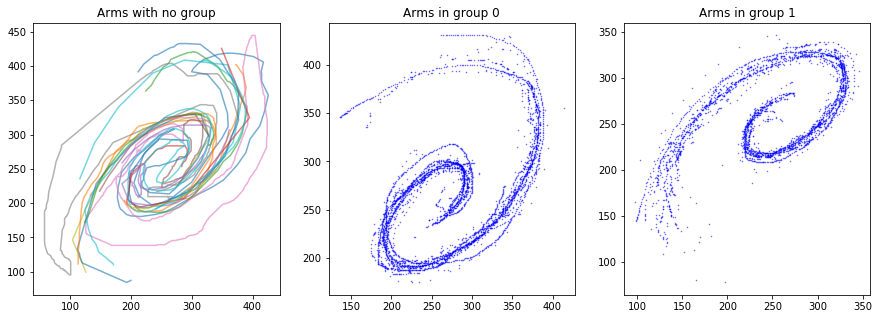

In [9]:
fig, ax = plt.subplots(ncols=len(np.unique(armLabels)), figsize=(15, 5))
for i, label in enumerate(np.unique(armLabels)):
    if label == -1:
        ax[i].set_title('Arms with no group')
    else:
        ax[i].set_title('Arms in group {}'.format(label))
    identified = drawnArms[np.where(armLabels == label)]
    for arm in identified:
        ax[i].plot(arm[:, 0], arm[:, 1], ('b.' if i > 0 else ''), markersize=1, alpha=0.6)


Well we have arms!!

The next step is to order the points in such a way we can fit a curved spline to them. We pick the arm with $\mathrm{label}=0$ to demonstrate

In [72]:
label = 0
pointCloud = np.array([
    point for arm in drawnArms[armLabels == label] 
    for point in arm
])

In [11]:
print('Total number of points:', np.array([point for arm in drawnArms for point in arm]).shape[0])
print('Arm 0 number of points:', pointCloud.shape)

Total number of points: 8101
Arm 0 number of points: (3743, 2)


In [13]:
from scipy.interpolate import UnivariateSpline

def rThetaFromXY(x, y, mux=0, muy=0):
    return np.sqrt((x - mux)**2 + (y - muy)**2), np.arctan2((y - muy),(x - mux))

def xyFromRTheta(r, theta, mux=0, muy=0):
    return mux + r*np.cos(theta), muy + r*np.sin(theta)

## Cleaning up the data

Let's make use of some outlier detection to clean up the data, 

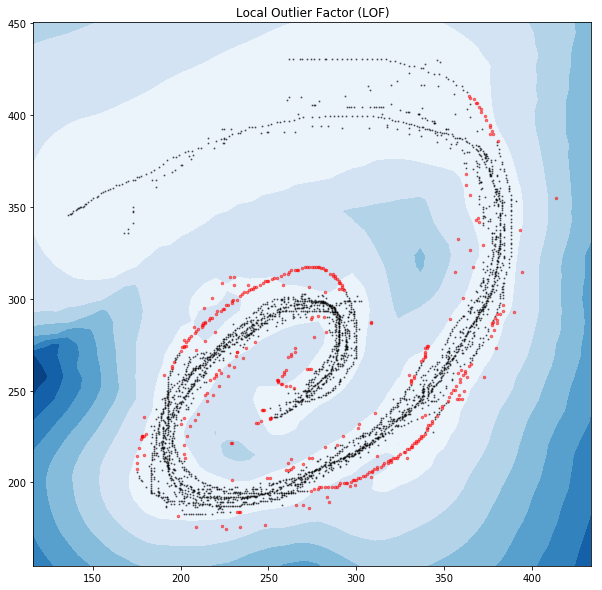

In [150]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=40)
y_pred = clf.fit_predict(pointCloud)
mask = ((y_pred + 1) / 2).astype(bool)
y_pred_outliers = y_pred[200:]
xx, yy = np.meshgrid(
    np.linspace(np.min(pointCloud[:, 0]) - 20, np.max(pointCloud[:, 0]) + 20, 50), 
    np.linspace(np.min(pointCloud[:, 1]) - 20, np.max(pointCloud[:, 1]) + 20, 50)
)
Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.set_title("Local Outlier Factor (LOF)")
ax.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
ax.plot(cleanedCloud[:, 0], cleanedCloud[:, 1], 'k.', markersize=2, alpha=0.5)
ax.plot(pointCloud[np.logical_not(mask), 0], pointCloud[np.logical_not(mask), 1], 'r.', markersize=5, alpha=0.5)

cleanedCloud = pointCloud[mask]

## Attempt 1: Principal component analysis

If we take a subsample of the data points, and at each point identify the principal component, we should end up with an overall "flow" of the data at that point. This (somehow) could be used to order / fit data to those points?

In [152]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
mask = np.ones(cleanedCloud.shape[0], dtype=bool) #np.random.randn(cleanedCloud.shape[0])>0
keyPoints = cleanedCloud[mask]

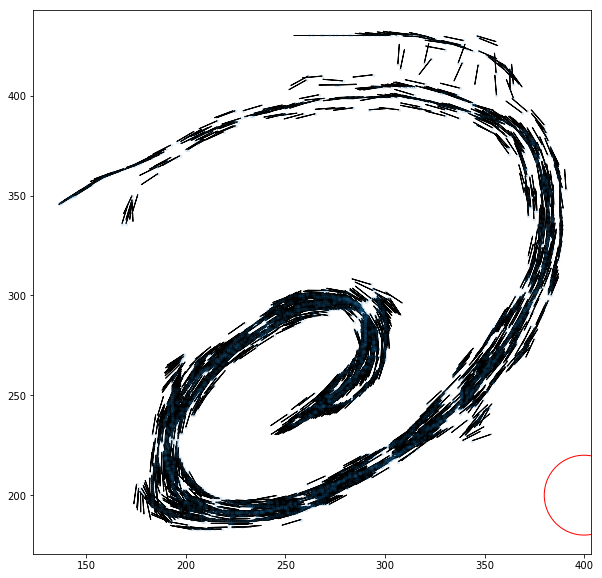

In [153]:
from matplotlib.patches import Ellipse
patchSize = 20
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.plot(cleanedCloud[:, 0], cleanedCloud[:, 1], '.', markersize=5, alpha=0.1)
vectors = np.zeros((keyPoints.shape[0], 2))
for i, point in enumerate(keyPoints):
    ax.plot(point[0], point[1], 'r', markersize=10, alpha=0.2)
    radialMask = np.add.reduce((cleanedCloud - point)**2, axis=1) < patchSize**2
    pcaResult = pca.fit(cleanedCloud[radialMask])
    vectors[i] = pcaResult.components_[0]
    ax.arrow(
        point[0], point[1],
        10*vectors[i][0], 10*vectors[i][1],
        width=0.0001, head_width=0, head_length=0,
        fc='k', ec='k'
    )
ax.add_artist(Ellipse(
    xy=[400,200],
    width=patchSize*2,
    height=patchSize*2,
    facecolor='none',
    edgecolor='r'
))

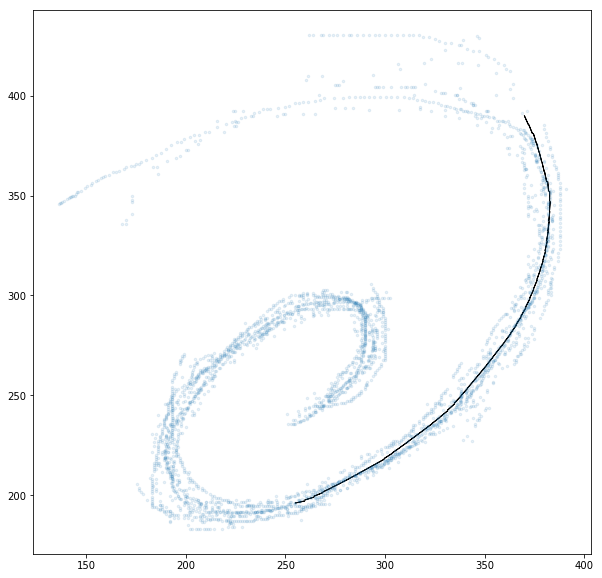

In [178]:
pos = [250, 195] # cleanedCloud[2300].copy()
stepSize = 5
patchRadius = 15

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.plot(cleanedCloud[:, 0], cleanedCloud[:, 1], '.', markersize=5, alpha=0.1)

nonZeroVectors = vectors[:, 0] > 0

for i in range(10000):
    radialMask = np.add.reduce((keyPoints - pos)**2, axis=1) < patchRadius**2
    combinedMask = np.logical_and(radialMask, vectors[:, 0] > 0)
    if(np.any(combinedMask)):
        theta = np.mean(rThetaFromXY(vectors[combinedMask, 0], vectors[combinedMask, 1])[1]%(np.pi))
        x, y = xyFromRTheta(10, theta)
        deltaPos = [x, y] / np.sqrt(x**2 + y**2) * stepSize
        pos += deltaPos
        ax.arrow(
            pos[0], pos[1],
            deltaPos[0], deltaPos[1],
            width=0.0001, head_width=0, head_length=0,
            fc='k', ec='k'
        )
    else:
        break

## Attempt 2: the way we did it before

So spectral clustering was suuuper slow, so we'll try agglomerative instead...

In [16]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

knn_graph = kneighbors_graph(pointCloud, 30, include_self=False)
model = AgglomerativeClustering(linkage='ward', connectivity=knn_graph, n_clusters=15)
model.fit(pointCloud)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=<3743x3743 sparse matrix of type '<class 'numpy.float64'>'
	with 112290 stored elements in Compressed Sparse Row format>,
            linkage='ward', memory=None, n_clusters=15,
            pooling_func=<function mean at 0x107884268>)

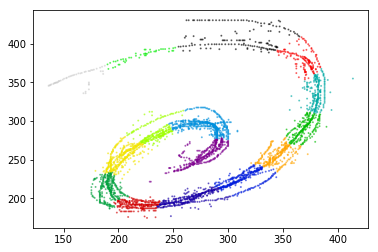

In [17]:
plt.scatter(pointCloud[:, 0], pointCloud[:, 1], c=model.labels_,
                        cmap=plt.cm.spectral, s=1, alpha=0.5)

In [18]:
sortedBatches = []
means = np.zeros((len(np.unique(model.labels_)), 2))
count = 0
pc2 = pointCloud - [250, 250]
for i, sublabel in enumerate(np.unique(model.labels_)):
    mask = model.labels_ == sublabel
    r, theta = rThetaFromXY(pc2[mask, 0], pc2[mask, 1])
    if min(theta) < -3*np.pi/4 and 3* max(theta) > np.pi/4:
        theta[theta < -np.pi / 2] += 2*np.pi
    args = np.argsort(theta)
    sortedBatches.append(pointCloud[mask][args])
    count += r.shape[0]
    means[i] = [np.mean(pc2[mask, 0]), np.mean(pc2[mask, 1])]

In [19]:
means

array([[ 62.25578231, 158.1292517 ],
       [ 28.15043988,   6.7914956 ],
       [ 14.83604651, -50.29331395],
       [ 63.15301587, -25.19174603],
       [ 29.33406114,  43.99650655],
       [130.68190045,  85.68190045],
       [-58.83410596, -37.6218543 ],
       [119.6253012 ,  40.55461847],
       [-30.08043478, 134.38478261],
       [-16.09156118,  35.07172996],
       [-46.46899441,   3.48575419],
       [ 94.54518519,   5.31592593],
       [118.63716216, 129.07635135],
       [-32.17315175, -58.52256809],
       [-89.568     , 105.274     ]])

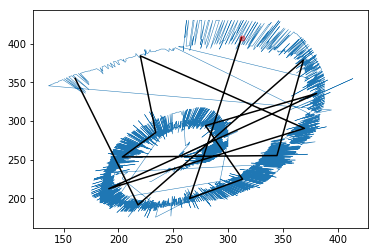

In [20]:
r, theta = rThetaFromXY(means[:, 0], means[:, 1])
a = np.argsort(r)
result = np.array([p for i in a for p in sortedBatches[i]])
plt.plot(result[:, 0], result[:, 1], linewidth=0.5)
plt.plot(means[:, 0]+250, means[:, 1]+250, 'k')
plt.plot(means[0, 0]+250, means[0, 1]+250, 'r.', markersize=10, alpha=0.4)

In [21]:
from sklearn.neighbors import BallTree
tree = BallTree(means)

In [22]:
dist, ind = tree.query([means[0]], k=5)
len(means), dist, ind

(15, array([[  0.        ,  63.4265797 ,  95.34032096,  99.65316024,
         118.78603976]]), array([[ 0, 12,  8,  5,  4]]))